### Import Dataset

In [5]:
import mung
from pycocotools.coco import COCO
from omrdatasettools import Downloader, OmrDataset
import os

import torch
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image
import pandas as pd
from PIL import Image
import json

In [6]:
downloader = Downloader()
downloader.download_and_extract_dataset(dataset=OmrDataset.MuscimaPlusPlus_V2, 
                                        destination_directory='muscima')
downloader.download_and_extract_dataset(dataset=OmrDataset.MuscimaPlusPlus_MeasureAnnotations,
                                        destination_directory="muscima/v2.0/data/measure")


Extracting MuscimaPlusPlus_V2 dataset...
Deleting temporary directory c:\Repositories\music\MuscimaPpImages
Extracting MuscimaPlusPlus_MeasureAnnotations dataset...


In [7]:
imagepath = 'muscima/v2.0/data/images'
annotationpath = 'muscima/v2.0/data/measure/json'

In [8]:
anns = list(sorted(os.listdir(annotationpath)))

anns[0]


'CVC-MUSCIMA_W-01_N-10_D-ideal.json'

In [9]:
with open(os.path.join(annotationpath, anns[0])) as f:
  sample_ann = json.loads(f.read())
  print(sample_ann.keys())
  #xmin = sample_ann['system_measures'][0]['bottom']
  #print(xmin)

objectlabels = ['system_measures', 'stave_measures', 'staves']

dict_keys(['width', 'height', 'system_measures', 'stave_measures', 'staves'])


In [4]:
objectlabels = ['system_measures', 'stave_measures', 'staves']
for idx, label in enumerate(objectlabels):
    print(idx)
    print(label)

0
system_measures
1
stave_measures
2
staves


In [ ]:
class MuscimaMeasures(Dataset):
  def __init__(self, imagepath, annotationpath, transforms=None):
    self.imgpath = imagepath
    self.annpath = annotationpath

    self.imgs = list(sorted(os.listdir(imagepath)))
    self.anns = list(sorted(os.listdir(annotationpath)))

    self.transforms = transforms

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    image = Image.open(os.path.join(self.imgpath, self.imgs[idx]))
    target = {}
    height = 0
    width = 0
    labels = []
    boxes = []
    iscrowd = []
    image_id = torch.tensor([idx])
    with open(os.path.join(self.annpath, self.anns[idx])) as f:
      annotations = json.loads(f.read())
      width = annotations['width']
      height = annotations['height']

      objs = annotations['system_measures']
      for i in range(len(objs)):
        xbox = np.asarray([objs[i]['left'], objs[i]['right']])
        ybox = np.asarray([objs[i]['top'], objs[i]['bottom']])
        
        xmin = np.min(xbox)
        xmax = np.max(xbox)
        ymin = np.min(ybox)
        ymax = np.max(ybox)
        boxes.append([xmin, ymin, xmax, ymax])
      labels = torch.ones(len(annotations['system_measures']), dtype=torch.int64)
      iscrowd = torch.zeros(len(annotations['system_measures']), dtype=torch.int64)
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    
    target['boxes'] = boxes
    target['labels'] = labels
    target['image_id'] = image_id
    target['area'] = area
    target['iscrowd'] = iscrowd

    if self.transforms is not None:
      image, target = self.transforms(image, target)

    return image, target

In [20]:
class MuscimaMeasures(Dataset):
  def __init__(self, imagepath, annotationpath, transforms=None):
    self.imgpath = imagepath
    self.annpath = annotationpath

    self.imgs = list(sorted(os.listdir(imagepath)))
    self.anns = list(sorted(os.listdir(annotationpath)))

    self.transforms = transforms

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    image = Image.open(os.path.join(self.imgpath, self.imgs[idx]))
    target = {}
    height = 0
    width = 0
    labels = []
    boxes = []
    iscrowd = []
    image_id = torch.tensor([idx])
    with open(os.path.join(self.annpath, self.anns[idx])) as f:
      annotations = json.loads(f.read())
      width = annotations['width']
      height = annotations['height']
    
      objectlabels = ['system_measures', 'stave_measures', 'staves']
    
      for idx, label in enumerate(objectlabels):
        objs = annotations[label]
        for i in range(len(objs)):
          xbox = np.asarray([objs[i]['left'], objs[i]['right']])
          ybox = np.asarray([objs[i]['top'], objs[i]['bottom']])
          
          xmin = np.min(xbox)
          xmax = np.max(xbox)
          ymin = np.min(ybox)
          ymax = np.max(ybox)
          boxes.append([xmin, ymin, xmax, ymax])
          labels.append(idx+1)
          iscrowd.append(0)
    boxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)
    iscrowd = torch.as_tensor(iscrowd, dtype=torch.int64)
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    
    target['boxes'] = boxes
    target['labels'] = labels
    target['image_id'] = image_id
    target['area'] = area
    target['iscrowd'] = iscrowd

    if self.transforms is not None:
      image, target = self.transforms(image, target)

    return image, target

In [21]:
from visionutils.engine import train_one_epoch, evaluate
from visionutils import utils
from visionutils import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [22]:
dataset = MuscimaMeasures(imagepath, annotationpath, get_transform(train=True))
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn)

In [23]:
sample_im, sample_ann = dataset[0]
sample_boxes = sample_ann['boxes']

sample_im = (255*sample_im).type(torch.ByteTensor)

In [18]:
print(torch.max(sample_im))



tensor(255, dtype=torch.uint8)


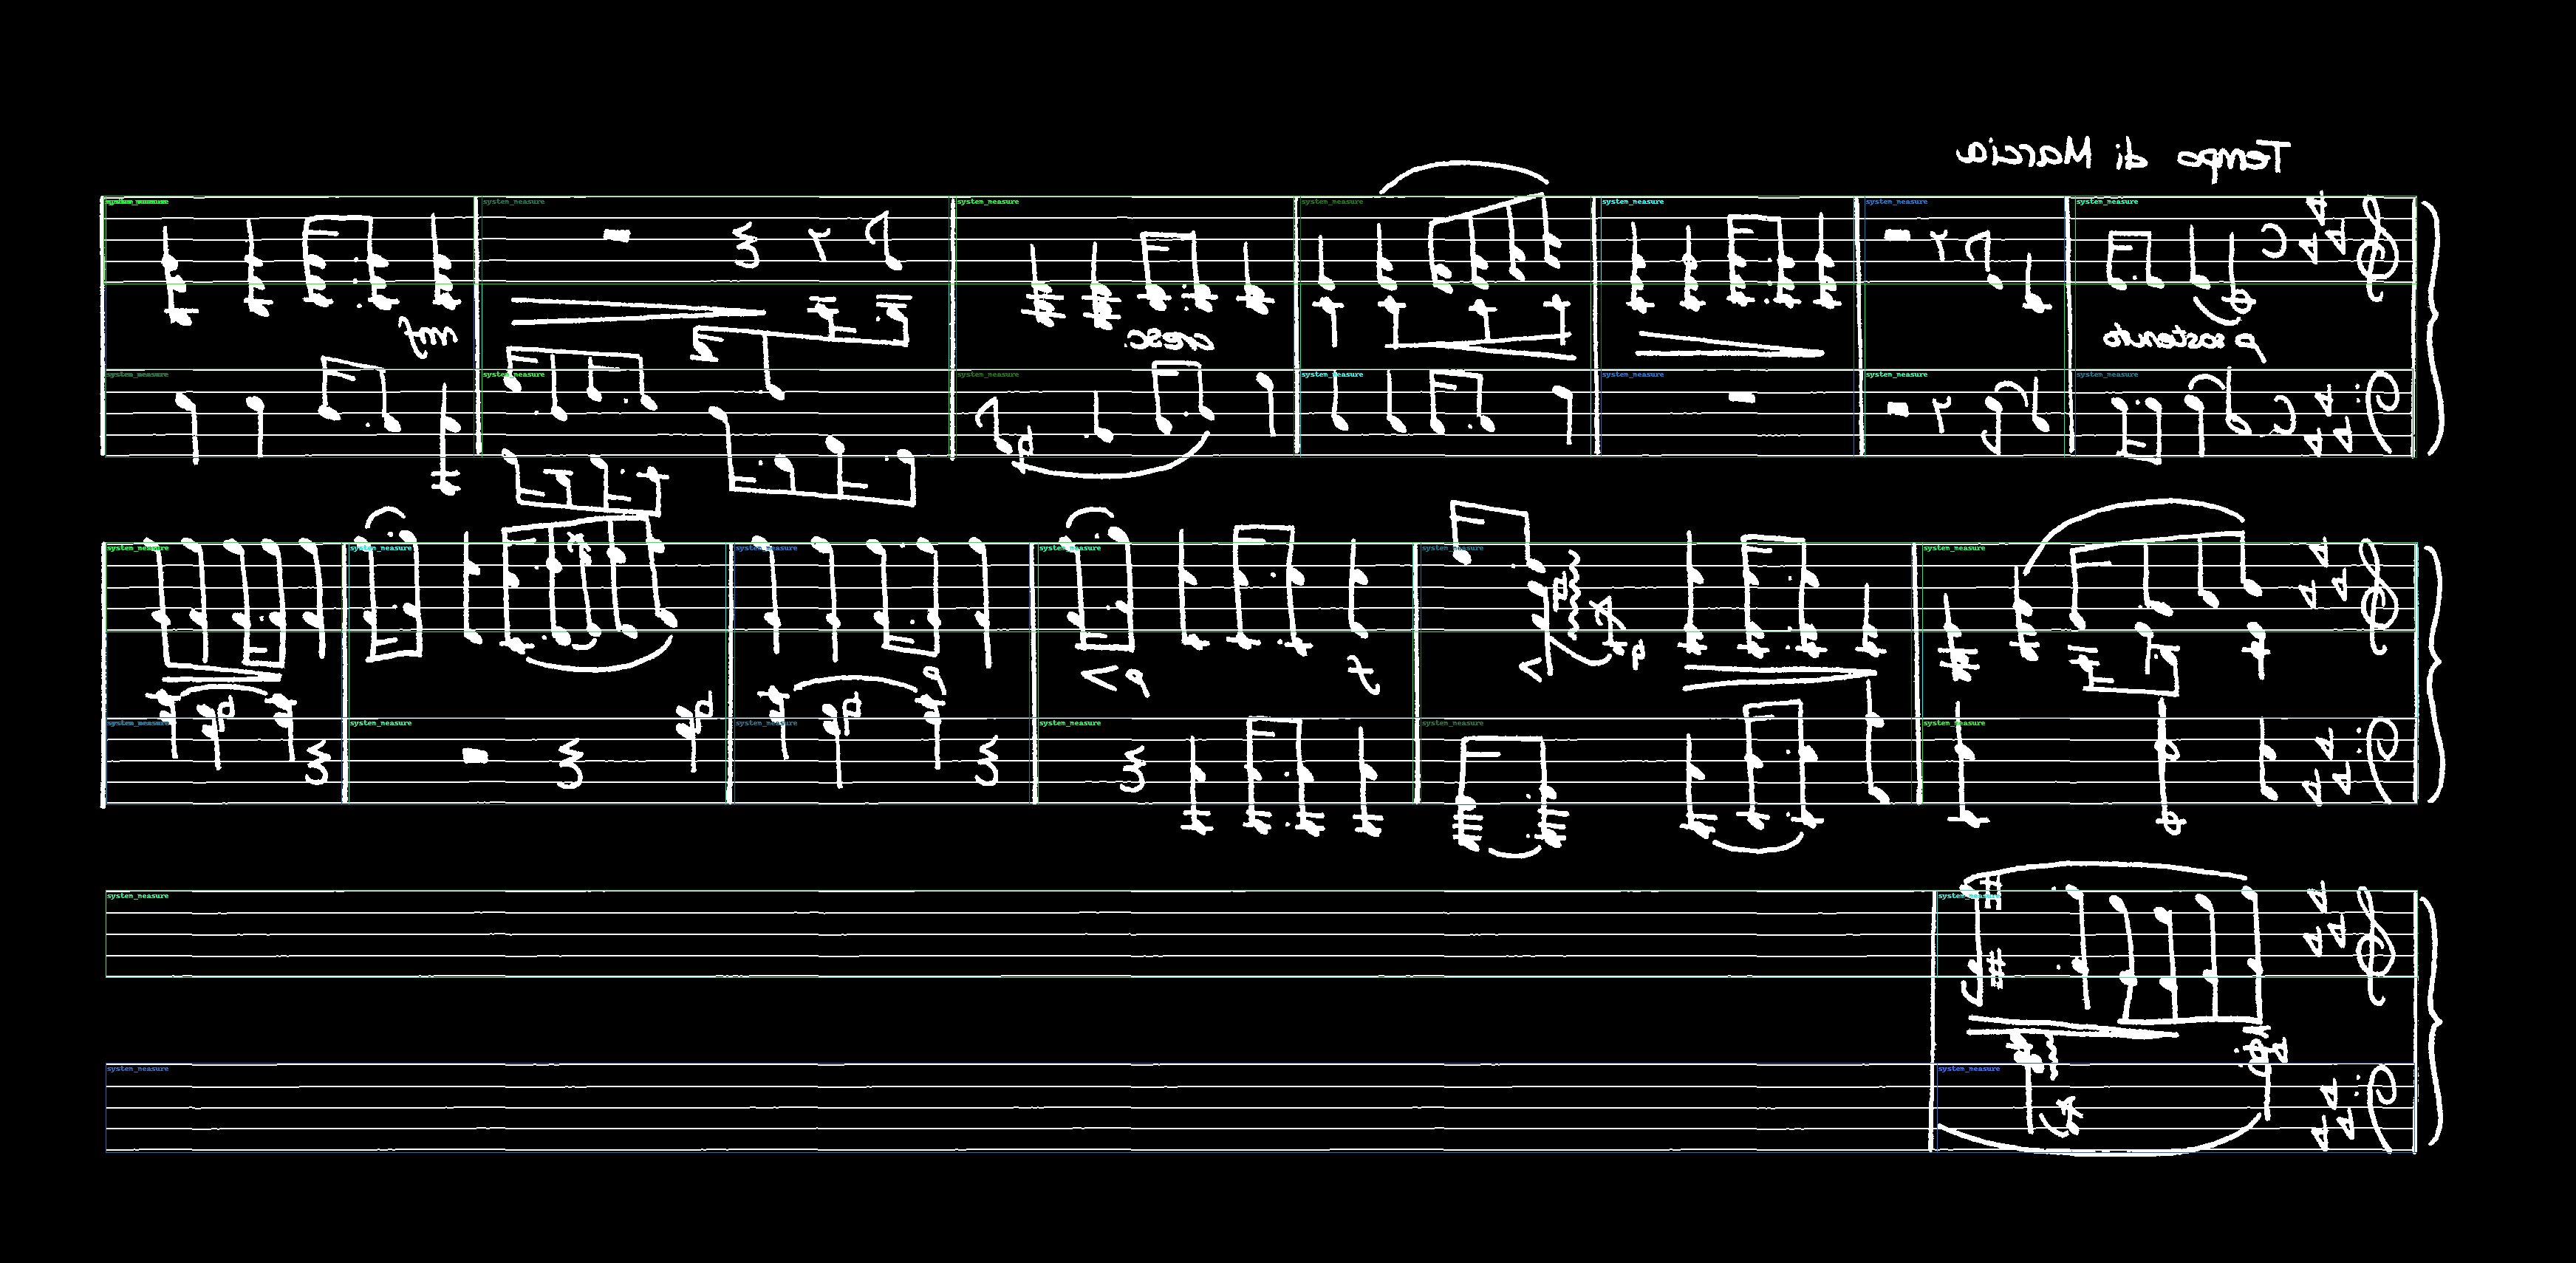

In [24]:
from torchvision.utils import draw_bounding_boxes

labels = ['system_measure' for i in range(sample_boxes.shape[0])]

sample_im_with_bounding_boxes = draw_bounding_boxes(sample_im, sample_boxes, labels)

sample_im_with_bounding_boxes.shape
Image.fromarray(np.moveaxis(sample_im_with_bounding_boxes.numpy(), 0, -1))

### Import Model

In [40]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Pretrained model
def get_faster_rcnn_with_n_classes(n: int):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

  in_features = model.roi_heads.box_predictor.cls_score.in_features

  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, n)

  return model

In [41]:
num_classes = 4

model = get_faster_rcnn_with_n_classes(num_classes)

In [42]:
# Test

images, targets = next(iter(dataloader))

images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
#targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)

model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x) 

In [43]:
dataset = MuscimaMeasures(imagepath, annotationpath, get_transform(train=True))
dataset_test = MuscimaMeasures(imagepath, annotationpath, get_transform(train=False))

#splits
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])

print(len(dataset))
print(len(dataset_test))

#dataloaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

100
40


In [44]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

# optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# learning rate 10x reduction every three epocs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [45]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

run_training_and_validation = True

if run_training_and_validation:
  for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/50]  eta: 0:00:38  lr: 0.000107  loss: 5.3267 (5.3267)  loss_classifier: 1.2226 (1.2226)  loss_box_reg: 0.3759 (0.3759)  loss_objectness: 3.1329 (3.1329)  loss_rpn_box_reg: 0.5954 (0.5954)  time: 0.7740  data: 0.0470  max mem: 3372
Epoch: [0]  [10/50]  eta: 0:00:29  lr: 0.001126  loss: 2.5602 (3.1140)  loss_classifier: 0.9208 (0.9911)  loss_box_reg: 0.6528 (0.6307)  loss_objectness: 0.1932 (0.7492)  loss_rpn_box_reg: 0.7325 (0.7431)  time: 0.7465  data: 0.0665  max mem: 4134
Epoch: [0]  [20/50]  eta: 0:00:21  lr: 0.002146  loss: 2.3948 (2.6496)  loss_classifier: 0.7638 (0.8489)  loss_box_reg: 0.6643 (0.6656)  loss_objectness: 0.1581 (0.4514)  loss_rpn_box_reg: 0.7109 (0.6836)  time: 0.7196  data: 0.0636  max mem: 4134
Epoch: [0]  [30/50]  eta: 0:00:14  lr: 0.003165  loss: 2.1263 (2.5082)  loss_classifier: 0.6666 (0.7803)  loss_box_reg: 0.7130 (0.6824)  loss_objectness: 0.0879 (0.3364)  loss_rpn_box_reg: 0.6239 (0.7091)  time: 0.7015  data: 0.0616  max mem: 4134
Epoch: [

### Visualize Results

In [124]:
def visualize_bboxes(image, target, labels=None, threshold=0.5):
    colors = ['000000', 'red', 'blue', 'green', 'yellow']
    sample_boxes = target['boxes']
    sample_scores = target['scores']
    sample_labels = target['labels']
    idx = torch.where(sample_scores > threshold)
    boxes_sliced = sample_boxes[idx]
    labels_sliced = sample_labels[idx].tolist()
    labels_list_str = None
    if labels is not None:
        labels_list_str = list(labels[val] for val in labels_sliced)
        colors_list = list(colors[val] for val in labels_sliced)
    sample_image = (image*255).type(torch.ByteTensor)

    sample_im_with_bounding_boxes = draw_bounding_boxes(sample_image, boxes_sliced, labels_list_str, colors=colors_list, width=3, font_size=32)

    return Image.fromarray(np.moveaxis(sample_im_with_bounding_boxes.numpy(), 0, -1))


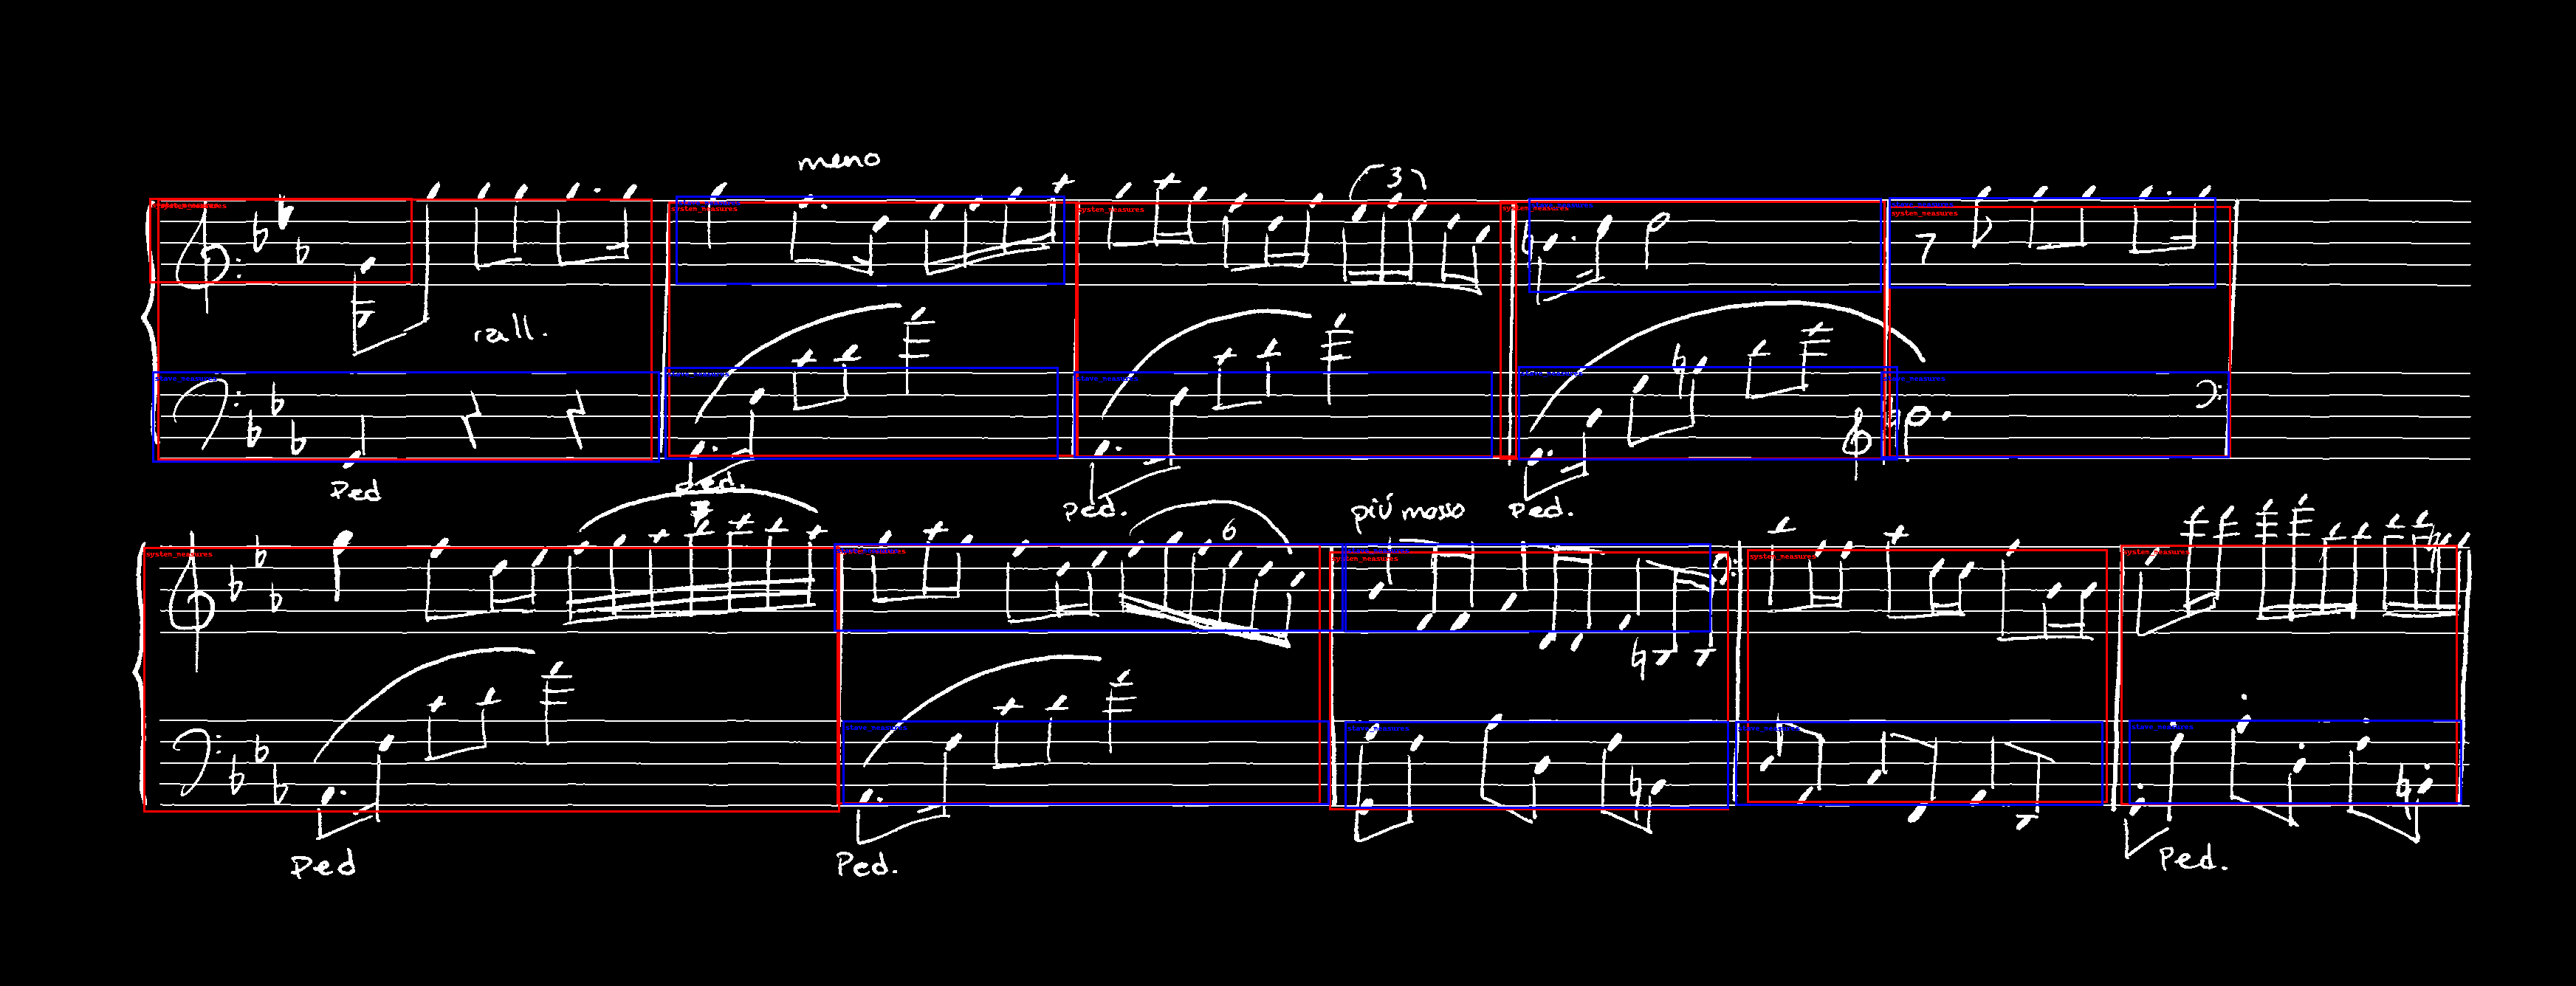

In [127]:
model.eval()
if torch.cuda.is_available():
  torch.cuda.synchronize()
image, target = next(iter(data_loader_test))
image = list(img.to(torch.device('cuda')) for img in image)
detections = model(image)
labels = {1: 'system_measures', 2: 'stave_measures', 3: 'staves'}
visualize_bboxes(image[0], detections[0], labels, threshold=0.8)

In [60]:
labels = {1: 'system_measures', 2: 'stave_measures', 3: 'staves'}
sample_labels = detections[0]['labels']
labels_list = sample_labels.tolist()

In [91]:
sample_boxes = detections[0]['boxes']
sample_scores = detections[0]['scores']
sample_labels = detections[0]['labels']
idx = torch.where(sample_scores > 0.5)
boxes_sliced = sample_boxes[idx]
labels_sliced = sample_labels[idx].tolist()
labels_list_str = None
if labels is not None:
    labels_list_str = []
    for ind in labels_sliced:
        labels_list_str.append(labels[ind])


In [117]:
labels_gen = list(labels[val] for val in labels_sliced)

['system_measures',
 'system_measures',
 'system_measures',
 'system_measures',
 'system_measures',
 'system_measures',
 'system_measures',
 'system_measures',
 'system_measures',
 'stave_measures',
 'stave_measures',
 'stave_measures',
 'stave_measures',
 'stave_measures',
 'system_measures',
 'stave_measures',
 'stave_measures',
 'stave_measures',
 'stave_measures',
 'system_measures',
 'stave_measures',
 'stave_measures',
 'stave_measures',
 'stave_measures',
 'stave_measures',
 'stave_measures',
 'stave_measures',
 'stave_measures',
 'stave_measures',
 'stave_measures',
 'stave_measures',
 'stave_measures',
 'system_measures']

[]

In [ ]:
num_images = 5
images_with_bboxes = []
for i in range(num_images):
  image, target = next(iter(data_loader_test))
  image = list(img.to(torch.device('cuda')) for img in image)
  detections = model(image)
  images_with_bboxes.append(visualize_bboxes(image[0], detections[0]))


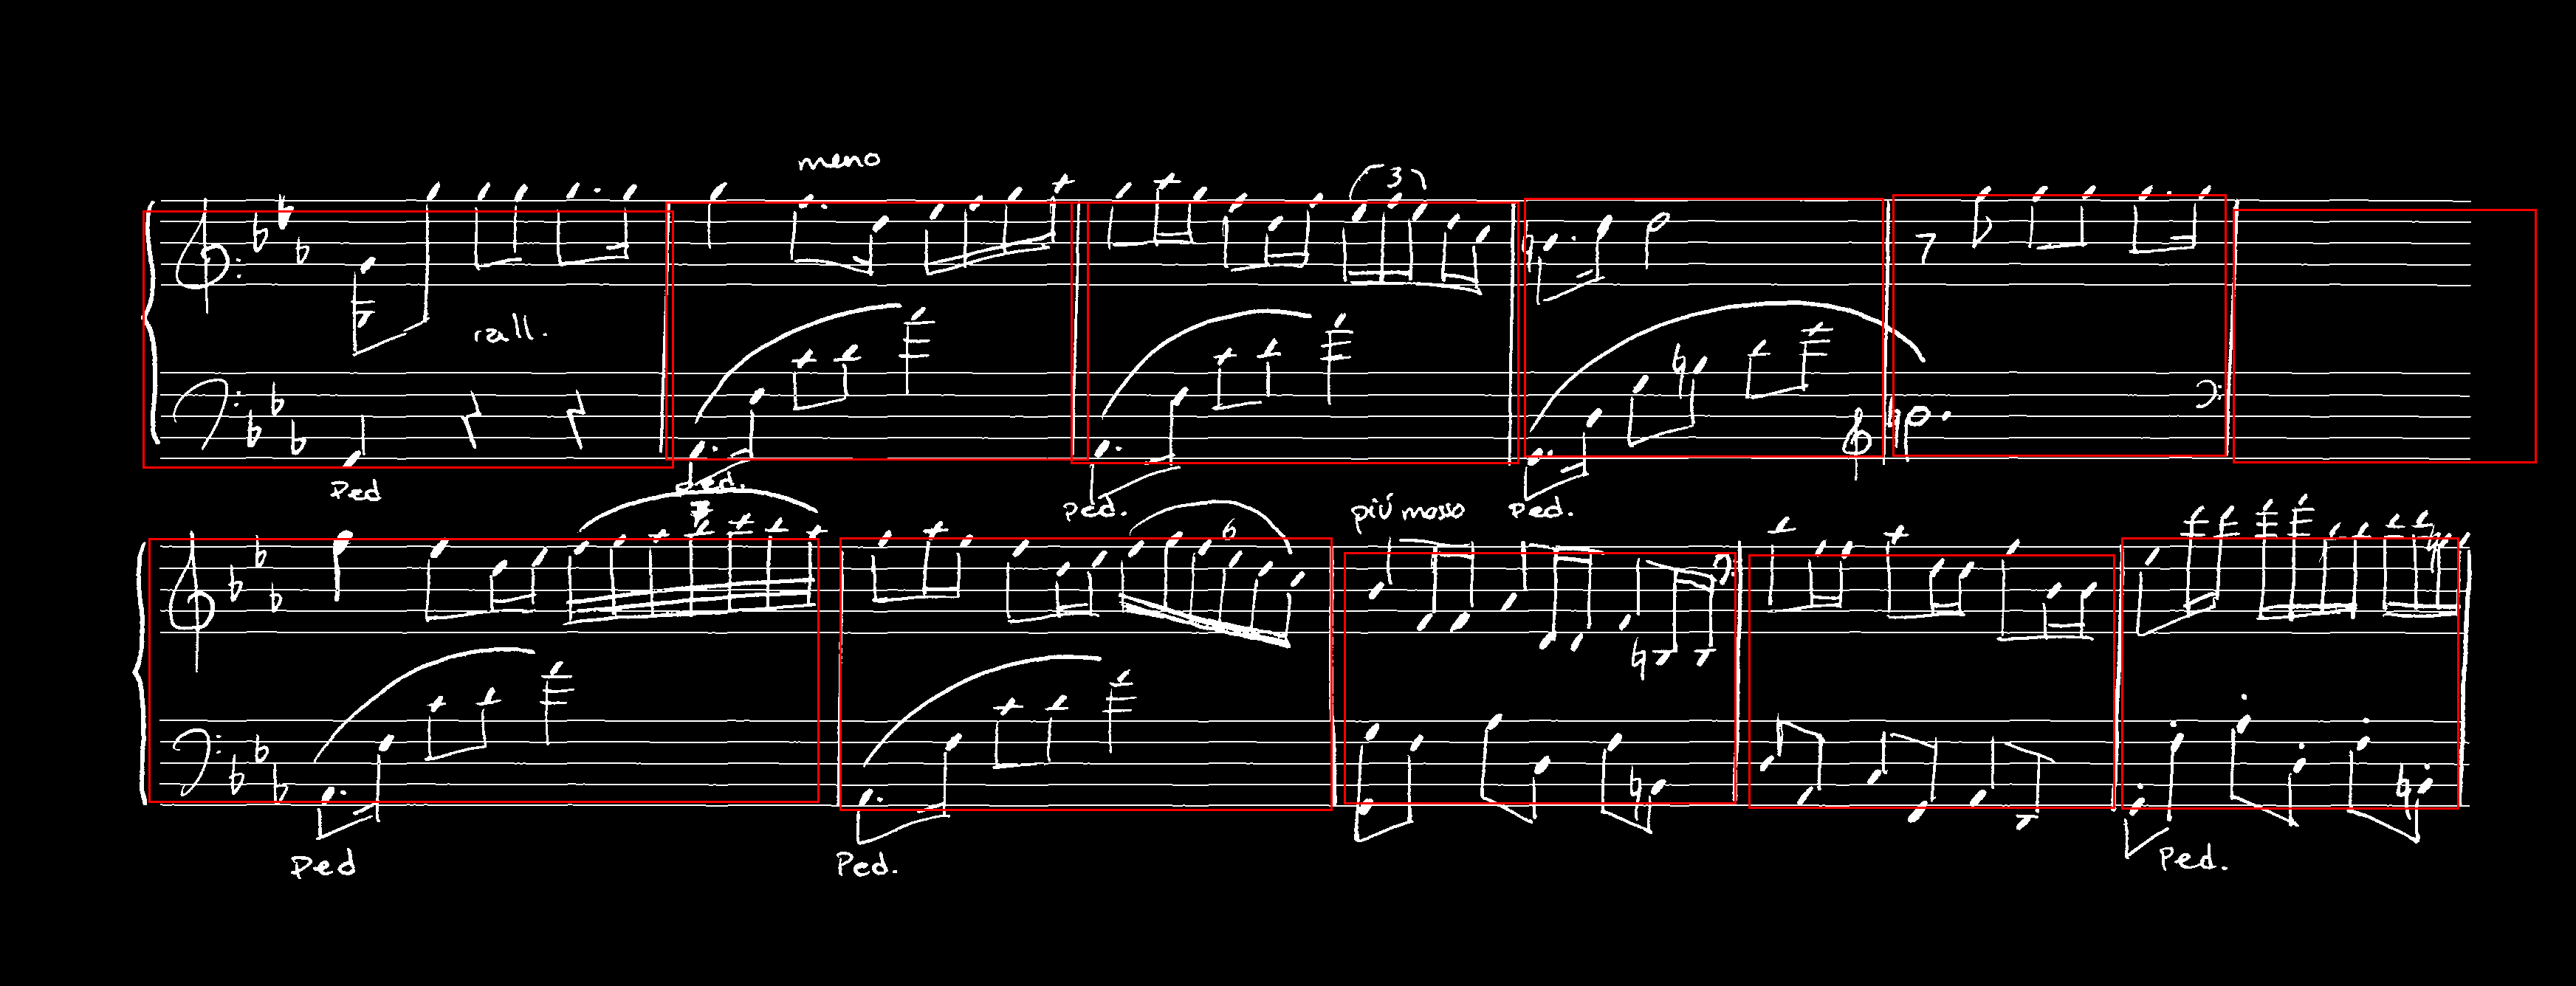

In [ ]:
images_with_bboxes[1]
images_with_bboxes[3]


### Save Model

In [ ]:
# Model state_dict
print("Model's state dict:")
for param_tensor in model.state_dict():
  print(param_tensor, "\t", model.state_dict()[param_tensor].size())

print()

# Optimizer state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
  print(var_name, "\t", optimizer.state_dict()[var_name])

In [ ]:
# Example only save parameters
SAVE_PARAMETERS = "state_dict_model.pt"

torch.save(model.state_dict(), SAVE_PARAMETERS)

model2 = get_faster_rcnn_with_n_classes(2)
model2.load_state_dict(torch.load(SAVE_PARAMETERS))

model2.eval()

In [ ]:
# Example save everything
SAVE_ENTIRE_MODEL = "entire_model.pt"

torch.save(model, SAVE_ENTIRE_MODEL)

model3 = torch.load(SAVE_ENTIRE_MODEL)
model3.eval()